# Import libraries

In [412]:
import pandas as pd

import torch
import statsmodels as sm

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import functools

import time

# Set constants

In [ ]:
# paths
FONT_PATH     = '../../../extra/Cinzel-VariableFont_wght.ttf'
DATASETS_PATH = '../../../data'
IMAGES_PATH   = '../../../images'
# colors
RED        = '#6F1D1B'
RICH_BLACK = '#011627'
# font size
SIZE_TICKS = 12

# Load fonts

In [414]:
cinzel_font = fm.FontProperties(fname=FONT_PATH)
fm.fontManager.addfont(FONT_PATH)

<h2> <center> pytorch implementation </center> </h2>

In [ ]:
"""
Time Series Forecasting Models
"""
class ModelsTorch():
    def __init__(self, data, device):
        if device == 'cuda' and not torch.cuda.is_available():
            raise RuntimeError('CUDA is not available')
        
        self.device = device
        # convert data to tensor and
        # move data to an operating device
        self.data = torch.from_numpy(data).to(device=device).float()


    """
    Simple Moving Average as Prediction
    or Moving Average Smoothing 
    != Moving Average Model 
    """
    @ModelsTorch.timer
    def SMA(self, window_size: int, 
                 showplot: bool=False):
        # synchronize GPU
        if self.device == 'cuda':
            torch.cuda.synchronize()

        # prepare data
        # increase dimensions (N,) -> (1, 1, N)
        # (needed for Conv1d)
        X = self.data.unsqueeze(0).unsqueeze(0)

        # create a tenzor of size (1, 1, window_size) filled with (1 / window_size) values
        kernel = torch.ones(1, 1, window_size, device=self.device) / window_size

        # perform convolution
        """
        e.g.:
        X      = [1,   2,   3,   4,   5]
        kernel = [1/w, 1/w, 1/w]

        (with a default stride=1)
        convolution = [
            1 * 1/w + 2 * 1/w + 3 * 1/w, 
            2 * 1/w + 3 * 1/w + 4 * 1/w, 
            3 * 1/w + 4 * 1/w + 5 * 1/w, 
        ]
        """
        # applies 1d convolution (actually cross-corellation)
        # the output length is (N - window_size + 1)
        predictions = torch.nn.functional.conv1d(X, kernel)

        # return to original shape (1, 1, N - window_size + 1) -> (N - window_size + 1,)
        # + drop last prediction, as it predicts the data outside of test data and 
        # is irrelevant for comparison with said data
        predictions = predictions.squeeze()[:-1]

        # drop first (window) amount of elements 
        # as they can't be predicted
        test = self.data[window_size:]

        # calculate RMSE
        rmse = ModelsTorch.RMSELoss(predictions, test)

        # synchronize GPU
        if self.device == 'cuda':
            torch.cuda.synchronize()

        # create plot
        if showplot:
            _, ax = plt.subplots(figsize=(8, 6))
            ax.plot(test, color='black', linewidth=1.5)
            ax.plot(predictions, color='red', linewidth=1.5)

            # plt.savefig(f'{IMAGES_PATH}/SMA_example_Dow_Jones_change.png', dpi=300, transparent=True)

            plt.show()

        return {
            'predicted': predictions,
            'rmse': rmse
        }


    """
    Helper functions
    """
    # calculate RMSE
    @staticmethod
    def RMSELoss(yhat, y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    

    # timer 
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.perf_counter()
            output = func(*args, **kwargs)
            result_time = time.perf_counter() - start_time

            if isinstance(output, dict):
                output['time'] = result_time
                return output
            return output

        return wrapper

In [416]:
plt.rcdefaults() # reset to defauls

<h2> <center> Simple Moving Average </center> </h2>

### Dow Jones Industrial Average

In [417]:
# load data
dowJones_df = pd.read_csv(
    f'{DATASETS_PATH}/DJIA.csv',
    parse_dates=['observation_date'],
    dayfirst=False
).set_index('observation_date').sort_index()

# fill missing values
dowJones_df.ffill(inplace=True)

# differentiate
dowJones_df['change'] = dowJones_df['DJIA'].diff()

X = dowJones_df['change'].dropna().values

# perform the ADF test
adf_result = sm.tsa.stattools.adfuller(X)

# interpret the results
p_value = adf_result[1]
significance_level = 0.05

if p_value <= significance_level:
    print("time series is likely STATIONARY.")
else:
    print("time series is likely NON-STATIONARY.")

# create objects
models_cpu = ModelsTorch(X, device='cpu')

try:
    models_gpu = ModelsTorch(X, device='cuda')
except Exception:
    print(f'CUDA is not available')

time series is likely STATIONARY.


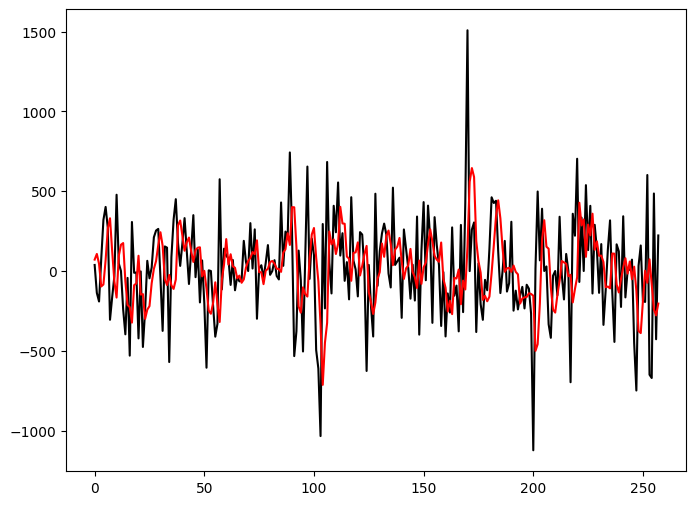

In [418]:
res = models_cpu.MA(window_size=3, showplot=True)

In [419]:
res_cpu = models_cpu.MA(window_size=3)
if models_gpu:
    res_gpu = models_gpu.MA(window_size=3)

print(f'cpu: {res_cpu['time']}s')
print(f'gpu: {res_gpu['time']}s')

cpu: 0.0008613659992988687s
gpu: 0.00035577299786382355s
